In [1]:
from jsonobject import *
import numpy as np 
import random
import math
import networkx as nx
from networkx.readwrite import json_graph
import matplotlib as mpl
import matplotlib.pyplot as plt

from copy import deepcopy

In [2]:
%matplotlib inline
plt.rcParams["figure.figsize"] = [10, 10] 

In [3]:
random.seed(2021)

# Classes

In [4]:
# Convolution
class Convolution(JsonObject):
    kernel = IntegerProperty()
    padding = StringProperty()
    stride = IntegerProperty()
    nb_filter = IntegerProperty()
    fct_activation = StringProperty()

In [5]:
# Input 
class InputLayer(JsonObject):
    shape = ListProperty(int)
    #shape = StringProperty()

In [6]:
# Pooling Avg/Max
class Pooling(JsonObject):
    op = StringProperty()
    kernel = IntegerProperty(default=2)
    padding = StringProperty(default="'valid'")
    stride = IntegerProperty(default=None)

In [7]:
# Class Flatten
class Flatten(JsonObject):
    pass

In [8]:
# Dense --> Fully connected layer
class Dense(JsonObject):
    nb_neurones =  IntegerProperty()
    fct_activation = StringProperty()

In [31]:
# identity block 
class IdBlock(JsonObject):
    kernel = IntegerProperty()
    padding = StringProperty()
    nb_filter = IntegerProperty()
    stride = 1

In [10]:
# convolution block
class ConvBlock(JsonObject):
    kernel = IntegerProperty()
    nb_filter = IntegerProperty()
    padding = StringProperty()
    stride = IntegerProperty()

# Test Graph
note : graph overkill

In [11]:
G = nx.Graph()

In [12]:
G.add_node("C1")
G.add_node("C2")
G.add_edge("C1","C2")
G.add_edge("C2","P1")
G.add_edge("P1","C3")
G.add_edge("C3","C4")
G.add_edge("C2","C4")
G.add_edge("C4","C5")

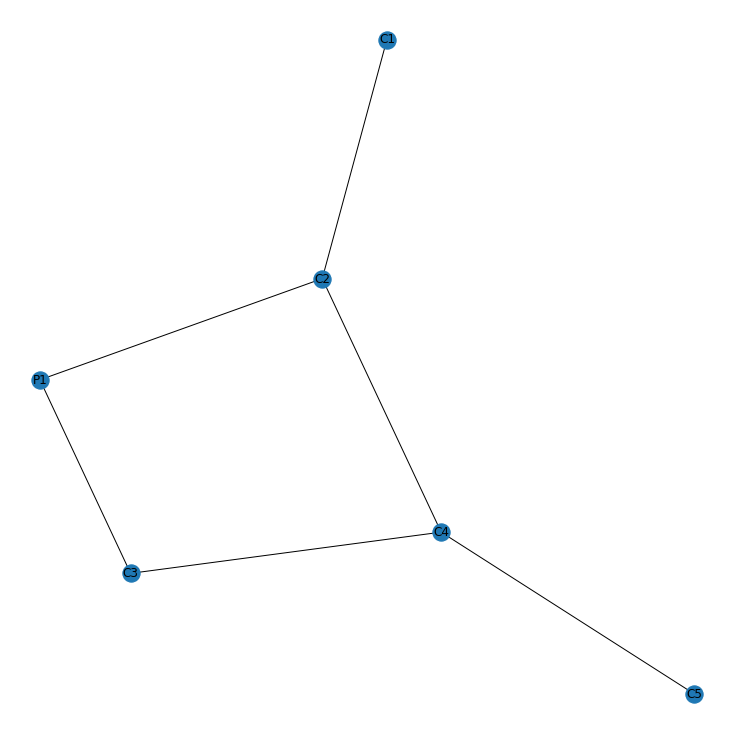

In [13]:
nx.draw(G, with_labels=True)
plt.show()

In [14]:
data = nx.node_link_data(G)

In [15]:
data

{'directed': False,
 'multigraph': False,
 'graph': {},
 'nodes': [{'id': 'C1'},
  {'id': 'C2'},
  {'id': 'P1'},
  {'id': 'C3'},
  {'id': 'C4'},
  {'id': 'C5'}],
 'links': [{'source': 'C1', 'target': 'C2'},
  {'source': 'C2', 'target': 'P1'},
  {'source': 'C2', 'target': 'C4'},
  {'source': 'P1', 'target': 'C3'},
  {'source': 'C3', 'target': 'C4'},
  {'source': 'C4', 'target': 'C5'}]}

# Value

In [16]:
layers_name = [Convolution, InputLayer, Pooling, Flatten, Dense]

# Table of hyperparameter value
kernel_value = [1, 2, 3, 4, 5, 6, 7]
stride_value = [1, 2, 3]
padding_value = ["valid", "same"]
#nb_filter_value = [6, 16, 64, 128, 256, 512, 1024, 2048]
fct_activation_value = ["tanh", "relu", "selu"]


nb_class = 10 # nb_class
op_value = ['avg',"max"]

# Function

In [17]:
def stop(size_archi, x):
    prob = x*size_archi-1*x
    if ( prob < random.randrange(101)):
        return True
    else : return False

In [18]:
def create_json_file(archi, file_name):
    directory = 'architecture_json/'
    
    # reset file
    archi_file = open(directory+file_name, "w")
    archi_file.close()
    
    # create file
    
    # open file
    archi_file = open(directory+file_name, "a")
    
    archi_file.write("""[
    """)
    
    archi_size = len(archi)
    i = 0
    for l in archi:

        str_layer = """\t{
            'class':'"""
        str_layer += l.__class__.__name__
        str_layer +="""',\n\t\t\t'parameters':"""
        str_layer += str(l.to_json())
        str_layer += """\n\t\t}"""
        if(i < archi_size-1):
            str_layer += ""","""
            i+=1
        str_layer = str_layer.replace("'","\"")
        
        archi_file.write(str_layer)
        
    archi_file.write("""\n]}]""")
    archi_file.close()

In [19]:
# compute the output 
# valid vs same
def calcul_output(input_size, l):
    output_size = 0
    if(l.padding == "valid"):
        kernel = l.kernel
        stride = l.stride
        while(input_size>=kernel):
            input_size -= stride
            output_size += 1   
    else:
        stride = l.stride
        if(input_size%stride == 0):
            output_size = int(input_size/stride)
        else:
            output_size = int(input_size/stride)+1
    return output_size

In [20]:
# add layer to architecture 

def addLayer(archi, layer):
    input_size = archi[0].shape[0]
    feature_extra = archi[1:]
    
    # add layer if the architecture is empty
    if(feature_extra == []):
        archi.append(layer)
        return 1, archi, calcul_output(input_size,layer)
    
    else :
        # compute size of the output of the last layer
        for l in feature_extra: 
            output_size = calcul_output(input_size, l)
            input_size = output_size
        
        # if we couldn't reduce more
        if(input_size == 1):
            return 0, archi, input_size
        
        # if the output size got more than 1 we can add new layer
        elif(output_size > 1): 
            output_size = calcul_output(input_size, layer)
            
            # if output size got negate is that the layer we want to add is wrong
            if(output_size < 1 ):
                return -1, archi, input_size
            # if output size is bigger than 0 we can add new layer and continue
            elif(output_size > 0):
                archi.append(layer)
                return 1, archi, output_size
            # this should not append
            else:
                return "Somethink wrong"
    # this should not append
    return "Error"

# Creation d'architecture

In [32]:
# init
extraction_feature= [IdBlock, ConvBlock]


architecture = list() # init architecture

nb_filter_value = 6*3 # init nb feature map
output_size = 32 

# add input Layer
architecture.append(InputLayer(shape=[28,28,1]))


# add extraction feature (succession of Pooling/convolution)
# Pooling can't be follow by a Pooling
pooling = True
code = 1 # we can add new layer
j = 2

kernel = 3

# add first conv

add_layer = Convolution(
    kernel=7, 
    padding=padding_value[random.randrange(2)], 
    stride=2, 
    nb_filter= nb_filter_value,
    fct_activation=fct_activation_value[random.randrange(3)]
)

code, architecture, output_size = addLayer(architecture, add_layer)


# add first pooling
add_layer = Pooling(
    op = op_value[random.randrange(2)],
    kernel=kernel, 
    padding=padding_value[random.randrange(2)], 
    stride=2
)
code, architecture, output_size = addLayer(architecture, add_layer)


while((stop(len(architecture),5)) & (code == 1)):
    layer = extraction_feature[random.randrange(2)]
    
    if(layer == ConvBlock):
        nb_filter_value = nb_filter_value*j
    
          
    if(layer == IdBlock):
        add_layer = IdBlock(kernel=kernel, padding='same', nb_filter=nb_filter_value)
    else:
        add_layer = ConvBlock(kernel=kernel, nb_filter=nb_filter_value, padding='same', stride=2)
    
    code, architecture, output_size = addLayer(architecture, add_layer)
    





try:
    nb_filter_value = architecture[len(architecture-1)-1]['nb_filter']
except:
    nb_filter_value = int(nb_filter_value/2)

print("output size : " + str(output_size))
print("nb_filter : " + str(nb_filter_value))
print("code: " + str(code))


# add flatten layer
architecture.append(Flatten())


# add dense Layer
param = output_size*output_size*(nb_filter_value)
print('param : ' + str(param))


## init values
pourcent = random.uniform(10,90)
nb=0
nb_neurones = int(param*pourcent/100)
    
print("nb_neurone : " + str(nb_neurones))
while(nb_neurones > nb_class):
    print("=====")
    print("iteration" + str(nb))
    print("nb_neurone : " + str(nb_neurones))
    
    dense = Dense(
        nb_neurones = nb_neurones,
        fct_activation = fct_activation_value[random.randrange(3)]
    )
    architecture.append(dense)
    
        
    #incrementation
    pourcent = random.uniform(10,90)
    nb+=1
    nb_neurones = int(nb_neurones*pourcent/100)


last_dense = Dense(
    nb_neurones = nb_class,
    fct_activation="softmax"           
)


architecture.append(last_dense)



                        
# print architecture
print(architecture)

# create file
file_name = "archi_resnet_test.json"
print(file_name)
print("")
create_json_file(architecture, file_name)

    
    
      

output size : 1
nb_filter : 72
code: 1
param : 72
nb_neurone : 49
=====
iteration0
nb_neurone : 49
[InputLayer(shape=[28, 28, 1]), Convolution(fct_activation='tanh', kernel=7, nb_filter=18, padding='valid', stride=2), Pooling(kernel=3, op='avg', padding='valid', stride=2), ConvBlock(kernel=3, nb_filter=36, padding='same', stride=2), IdBlock(kernel=3, nb_filter=36, padding='same', stride=1), ConvBlock(kernel=3, nb_filter=72, padding='same', stride=2), IdBlock(kernel=3, nb_filter=72, padding='same', stride=1), ConvBlock(kernel=3, nb_filter=144, padding='same', stride=2), Flatten(), Dense(fct_activation='tanh', nb_neurones=49), Dense(fct_activation='softmax', nb_neurones=10)]
archi_resnet_test.json

